In [50]:
import pandas as pd
ratings = pd.read_csv('ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv('movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']

In [54]:
movies_head = movies.copy()
movies_head.drop('Genres', axis=1, inplace=True)
movies_head.head(20)

,MovieID,Title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
5,6,Heat (1995)
6,7,Sabrina (1995)
7,8,Tom and Huck (1995)
8,9,Sudden Death (1995)
9,10,GoldenEye (1995)


In [35]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [28]:
# Get set of unique genres
genres = set()
for movie in movies['Genres']:
    genres.update(movie.split('|'))
genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [29]:
rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
rating_merged

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,White Boys (1999),Drama
1000207,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western


In [37]:
# Find most popular movie in given genre, return movie id and title

def most_popular(genre):
    genre_ratings = rating_merged[rating_merged['Genres'].str.contains(genre)]
    id = genre_ratings.groupby('MovieID').size().sort_values(ascending=False)[:10]
    return movies[movies['MovieID'].isin(id.index)][['MovieID', 'Title']]

most_popular("Action")

# Save most popular movies in each genre to one json file
import json
genre_dict = {}
for genre in genres:
    genre_dict[genre] = most_popular(genre).to_dict('records')
    
with open('most_popular.json', 'w') as outfile:
    json.dump(genre_dict, outfile)


# Read json file and print most popular movies in each genre
with open('most_popular.json') as json_file:
    data = json.load(json_file)
    for genre in data:
        print(genre)
        for movie in data[genre]:
            print(movie['Title'])
        print("\n")

Text(0, 0.5, 'Rating')

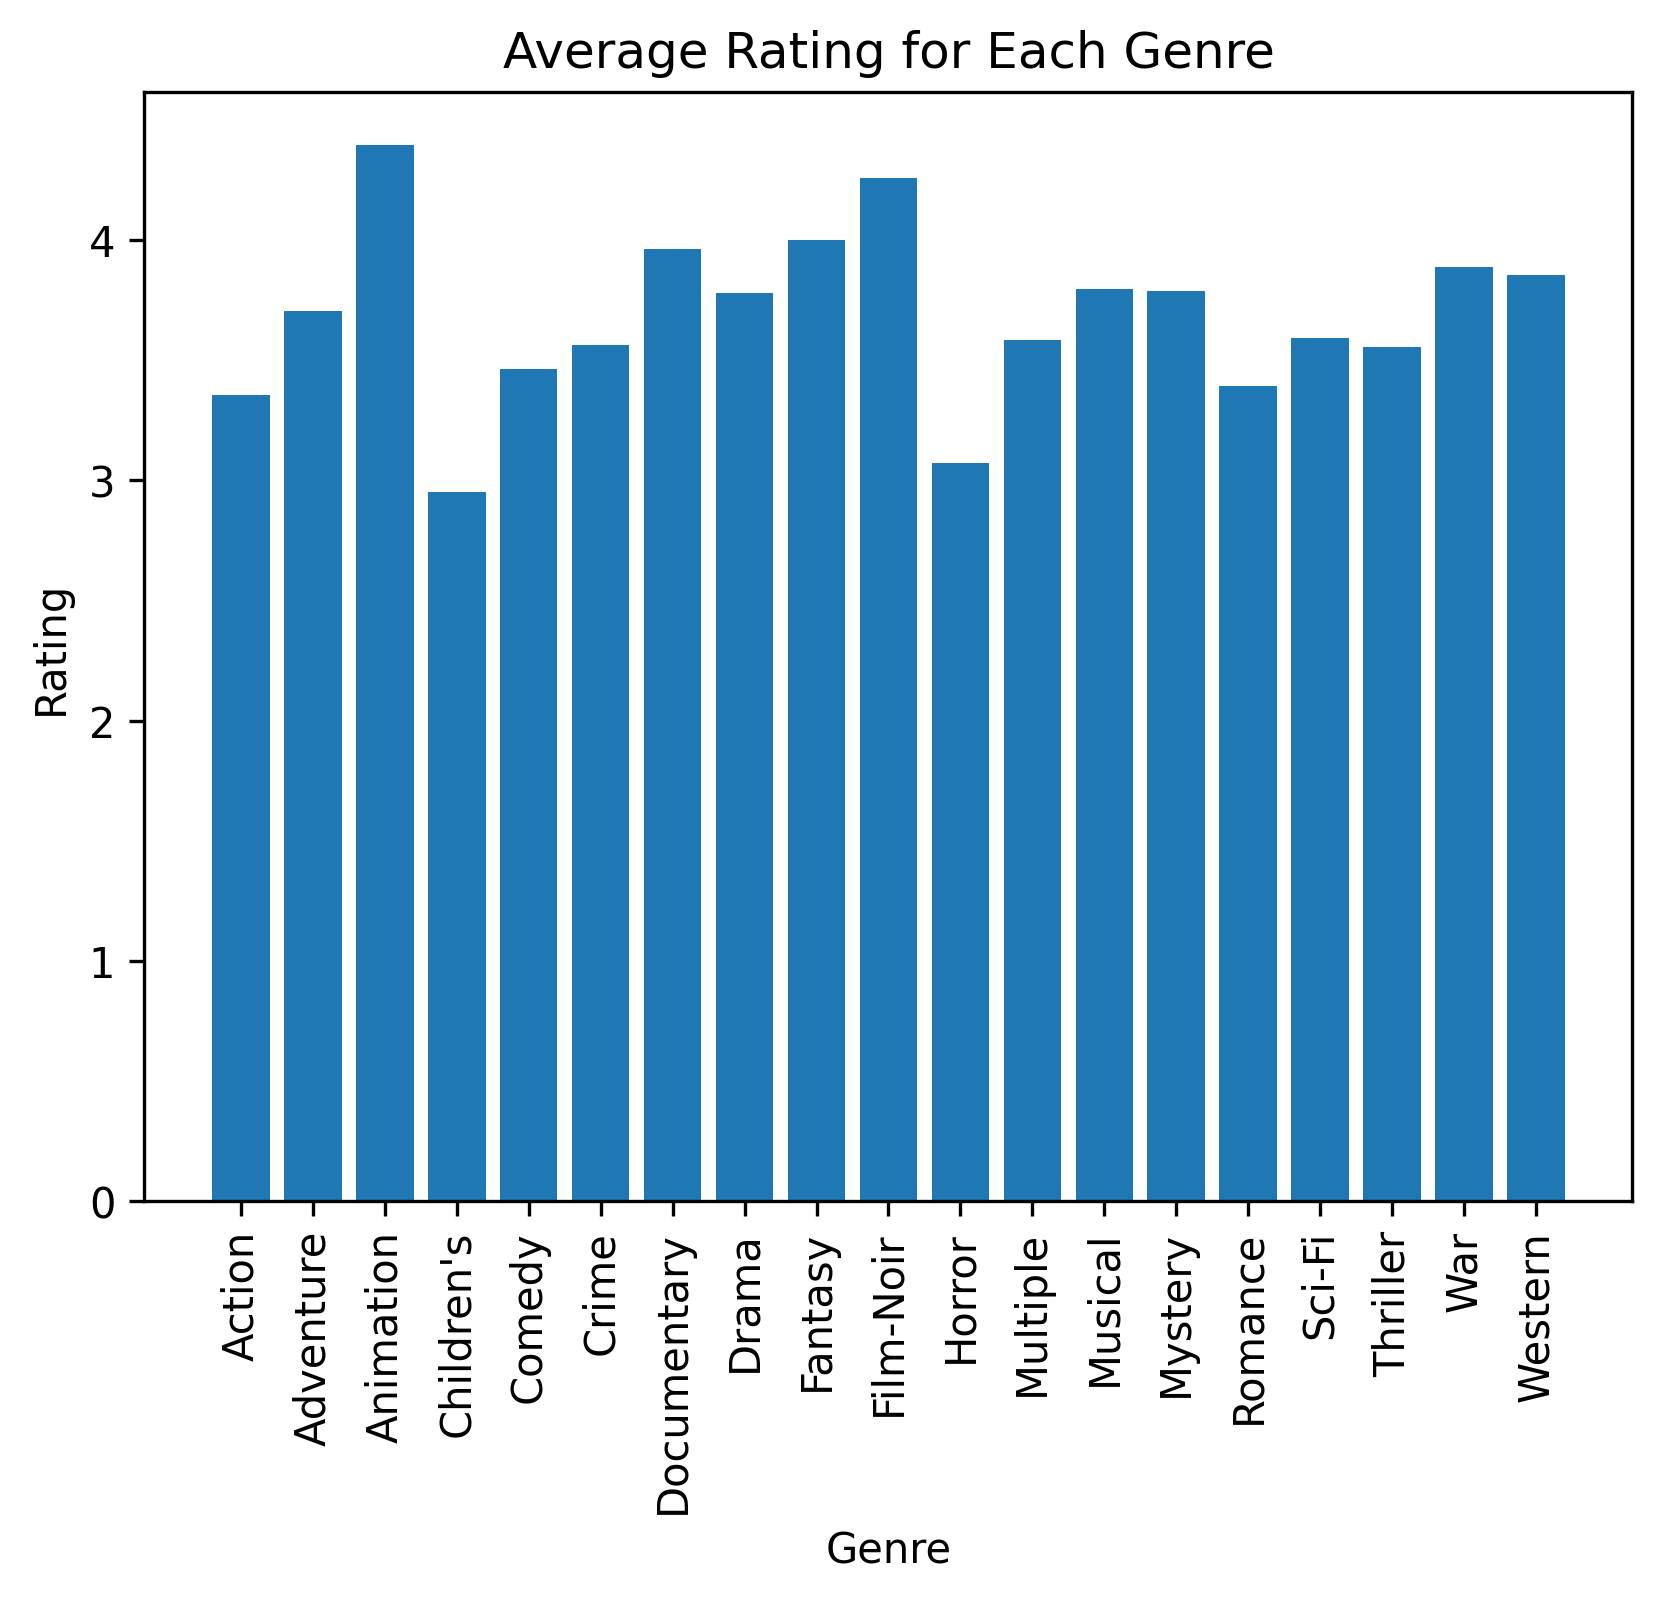

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
# sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()
plt.bar(mean_ratings.index, mean_ratings['Rating'])
plt.xticks(rotation=90)
plt.title('Average Rating for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')

In [6]:
from surprise import Dataset, Reader
ratings = ratings.drop('Timestamp', axis = 1)
ratings.columns = ['userID', 'itemID', 'rating']
ratings = ratings[['itemID', 'userID', 'rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userID", "itemID", "rating"]], reader)

In [7]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size = 0.25)

In [8]:
from surprise.prediction_algorithms.knns import KNNWithZScore
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNWithZScore(sim_options=sim_options).fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [9]:
import numpy as np
preds = [algo.predict(uid, iid).est for uid, iid, _ in testset]
results_table = pd.DataFrame(np.stack([testset])[0], 
                             columns = ['itemID', 'userID', 'rating'])
results_table['predicted'] = preds
results_merged = results_table.merge(movies, 
                                     left_on = 'itemID', right_on = 'MovieID')
results_merged = results_merged.drop('itemID', axis = 1)
results_merged.sort_values('userID')

,userID,rating,predicted,MovieID,Title,Genres
152586,1.0,5.0,4.283564,3857,Bless the Child (2000),Thriller
5806,1.0,3.0,3.920251,3014,Bustin' Loose (1981),Comedy
138658,1.0,5.0,4.373382,2766,"Adventures of Sebastian Cole, The (1998)",Multiple
41828,1.0,4.0,3.970724,392,"Secret Adventures of Tom Thumb, The (1993)",Multiple
21735,1.0,4.0,3.333346,1968,"Breakfast Club, The (1985)",Multiple
...,...,...,...,...,...,...
71981,3952.0,4.0,3.720508,1701,Deconstructing Harry (1997),Multiple
98997,3952.0,4.0,3.220735,2244,"Allnighter, The (1987)",Multiple
121521,3952.0,4.0,3.672114,1099,"Christmas Carol, A (1938)",Drama
70668,3952.0,5.0,3.908053,3483,"Road to El Dorado, The (2000)",Multiple
